##### Function to hide code cells

In [1]:
#!pip install pandas-datareader

In [2]:
from IPython.core.display import display, HTML
show_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
'''

show_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(show_code_prepare_str + show_code_str))

def show_code():
    display(HTML(show_code_str))

##### Dependencies

In [3]:
show_code()

import pandas as pd
import numpy as np
import requests
import pandas_datareader as pdr
from functools import reduce
import os
from datetime import date, datetime
import ipywidgets as widgets
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy.stats
from scipy import stats
from sklearn.metrics import r2_score
from statistics import mean, stdev
from math import sqrt
from builtins import float
    
pd.options.mode.chained_assignment = None  
pd.set_option("display.max_rows", None, "display.max_columns", None)

Matplotlib is building the font cache; this may take a moment.


##### Establish a directory and file storage structure

In [4]:
show_code()
## Repository file
directory = r"C:\Users\randy\OneDrive\Desktop\Capstone"
if not os.path.exists(directory):
    os.mkdir(directory)
    
## Make repoistory the directory    
os.chdir(directory)

## Storage for all csv files
temp_file_dir = os.path.abspath('Data_Files')
if not os.path.exists(temp_file_dir):
    os.mkdir(temp_file_dir)
    
## Final dataframe file    
finished_file_name = "finished_file.csv"
finished_csv_file = os.path.join(temp_file_dir, finished_file_name)

#####  Locate API key for FRED database

In [5]:
show_code()
key_file = open('fredapi.txt')
key = key_file.readline().rstrip()

# Functions

##### Function for extracting data series information and performing aggregate calculations from within

In [6]:
show_code()

def get_series_data(series, feature_name, start_date, end_date, split_date):
    '''
    Get complete series id list and process whole list as a dataframe
    Main output being the percent change for each location within a given timeframe
    '''
    ## Access the Fred API with given parameters
    url = 'https://api.stlouisfed.org/geofred/series/data'
    params = {'series_id': series,'api_key': key,'file_type': 'json'}
    
    ## Grab the data trhough the Fred API
    response = requests.get(url, params = params)
    r = response.json()
    
    ## Create a list and dataframe of related series id's from the given initial id
    id = list(r['meta']['data'].keys())[0]
    df1 = pd.DataFrame(r['meta']['data'][id])
    
    ## Return the list of series id's to be processed
    series_list = df1['series_id'].tolist()
    
    ## Download all series id information from list
    df2 = pdr.DataReader(series_list,'fred', start_date, end_date)
    df2 = df2.reset_index()
    
    ## Transform the data for ease of merging other data
    df3 = pd.melt(df2, id_vars=['DATE'], value_vars=series_list, var_name='series_id', value_name=feature_name)
    ## Add the region specific information back into the dataframe 
    df4 = pd.merge(df1,df3, on = 'series_id')
    
    ## Split the data into two groupings based off of the date split date
    split_1df = df4.loc[df4['DATE'] <= split_date]
    split_2df = df4.loc[df4['DATE'] > split_date]
    
    ## Find the percent change of the given feature and final grouping
    split_1df[f'{feature_name}_%_({start_date}_To_{split_date})'] = (split_1df.groupby('region')[feature_name].apply(pd.Series.pct_change)).fillna(0)
    split_2df[f'{feature_name}_%_({split_date}_To_{end_date})'] = (split_2df.groupby('region')[feature_name].apply(pd.Series.pct_change)).fillna(0)
    
    ## Group items and retrieve latest data from grouping
    split_11df = split_1df.groupby(['region'])[f'{feature_name}_%_({start_date}_To_{split_date})'].sum().to_frame().reset_index()
    split_22df = split_2df.groupby(['region'])[f'{feature_name}_%_({split_date}_To_{end_date})'].sum().to_frame().reset_index()
    
    ## Add the most recent non-aggregated value back within the dataframe
    df_1 = split_11df
    df_2 = split_2df[['region', feature_name]].merge(split_22df[['region', f'{feature_name}_%_({split_date}_To_{end_date})']], on = 'region', how = 'inner')
     
    ## Regroup the data and select only the last item for a summarized view of location
    df_2 = df_2.groupby(['region'])[[feature_name, f'{feature_name}_%_({split_date}_To_{end_date})']].last()
    df_2 = df_2.reset_index()
    
    ## Merge the two split dataframes together to create prior and current percentage change columns
    df = pd.merge(df_1, df_2, on = 'region')
    ## Reorganize the location of columns
    df = df[['region', feature_name, f'{feature_name}_%_({start_date}_To_{split_date})', f'{feature_name}_%_({split_date}_To_{end_date})']]
    df = df.set_index('region')
    
    return (df)

##### Statistical and Practical Significance Testing Function

In [7]:
show_code()
def ptest(df1, df2, i,category):
      
    def get_variable_name(*variable):
        return [ k for k,v in globals().items() if v is variable[0]][0]
    v1 = get_variable_name(df1)
    v2 = get_variable_name(df2)
   
    for index, row in df1.iterrows(): #Difference between columns at row level
        meanDifference1 = pd.DataFrame(df1.iloc[:,i]  - df1.iloc[:,i-1])
         
    for index, row in df2.iterrows(): #Difference between columns at row level
        meanDifference2 = pd.DataFrame(df2.iloc[:,i]  - df2.iloc[:,i-1])
                   
    len_1 = len(meanDifference1.iloc[:,0])
    len_2 = len(meanDifference2.iloc[:,0])
    mean_1 = meanDifference1.iloc[:,0].mean() 
    mean_2 = meanDifference2.iloc[:,0].mean() 
    var_1 = np.var(meanDifference1.iloc[:,0]) 
    var_2 = np.var(meanDifference2.iloc[:,0]) 
                
    cohens_d = (meanDifference1.iloc[:,0].mean() - meanDifference2.iloc[:,0].mean()) / \
    (sqrt((stdev(meanDifference1.iloc[:,0]) ** 2 + stdev(meanDifference2.iloc[:,0]) ** 2) / 2))

    t_test = stats.ttest_ind_from_stats(mean_1, np.sqrt(var_1), len_1, mean_2, np.sqrt(var_2), len_2, equal_var = False)
    t = t_test[1].astype(float)
    t_test = FormattedFloat(t_test[1])
    
    result = []
    if mean_1 > mean_2:
        result.append(v1)
    else:
        result.append(v2)
        
    if  (t < .05) & (cohens_d > .40):
        for word in result:
            if word not in filter_list:
                filter_list.append(word)
    
    sns.set_theme()
    f, axes = plt.subplots(2,1,sharex=True, figsize=(15,10))
    plt.text(x=0.5, y=1.0, s=f'''{category} Percent Change:
    {v1} & {v2}''', fontsize=22, color = 'midnightblue' , ha="center", transform=f.transFigure)
    plt.text(x=.129, y=.90, s= (f'P-value = {t_test}'), fontsize=14, color='midnightblue', ha="left", transform=f.transFigure)
    plt.text(x=.129, y=.93, s= f'Cohen\'s d = {cohens_d}', fontsize=14,color='midnightblue', ha="left", transform=f.transFigure)
    plt.text(x=.58, y=.93, s= f'Period1  = {start_date} to {split_date}', fontsize=14,color='midnightblue', ha="left", transform=f.transFigure)
    plt.text(x=.58, y=.90, s= f'Period2 = {split_date} to {end_date}', fontsize=14,color='midnightblue', ha="left", transform=f.transFigure)
    sns.boxplot(ax=axes[0], x=meanDifference1.iloc[:,0])
    axes[0].set_xlabel(f'{v1} difference between period2 and period1', fontsize = 18)
    #axes[0].set_ylabel('Difference Between Period2 and Period1', fontsize = 15)
    sns.boxplot(ax=axes[1], x=meanDifference2.iloc[:,0])
    axes[1].set_xlabel(f'{v2} difference between period2 and period1',fontsize = 18)
    axes[1].set_ylabel('')
    
    plt.show()
    


#### Final Combiner Function

In [8]:
show_code()
def combiner(Trend_filter,Period_1,Period_2,State,ShowAll):
    
    names_list = ['Population Period_1','Population Period_2','GDP Period_1','GDP Period_2',
                  'Home Price Period_1','Home Price Period_2','Work Force_ Period_1','Work Force Period_2',
                  'Cost Of Living Period_1','Cost Of Living Period_2']
    if Trend_filter:
        d = pd.concat(filter_list).drop_duplicates()
    else:
        d=df
    cols = list(d.columns)
    features = [cols[0], cols[2],cols[3],cols[5], cols[6],cols[8], cols[9],cols[11],cols[12],cols[14],cols[15]]
    d['Combined_Values'] = (d[cols[2]] * (Period_1)) + \
                            (d[cols[3]] * (Period_2)) + \
                            (d[cols[5]] * (Period_1)) + \
                            (d[cols[6]] * (Period_2)) + \
                            (d[cols[8]] * (Period_1)) + \
                            (d[cols[9]] * (Period_2)) + \
                            (d[cols[11]] * (Period_1)) + \
                            (d[cols[12]] * (Period_2)) - \
                            (d[cols[15]] * (Period_2)) 

    
    ## Remove any locations that have a negative value within a column
    d = d[(d[cols[2]]>.02) & (d[cols[3]]>.02) & (d[cols[5]]>0) & (d[cols[6]]>0) & (d[cols[8]]>0) & (d[cols[9]]>0)]
    
    #if Population:
    #    d = d[(d[cols[2]] > d[cols[2]].quantile(Population)) & (d[cols[3]] > d[cols[3]].quantile(Population))]
            
        
    ## Sort by the created combined column
    d.sort_values(by = 'Combined_Values', ascending = False, inplace = True)
    
    d.reset_index(inplace=True, drop=True)
    
    ## Display as the familiar percent value
    d.iloc[:,1:] = round(d.iloc[:,1:] * 100,2)
    
    ## Conditional views
    print("")
    if State:
        d = d[d['region'].str.contains(State.upper())]
    if ShowAll:
        d=d
    else:
        d = d.head(30)
    d = d[features]
    
    d.columns = d.columns[:1].tolist() + names_list
    ## Save results to a file for future access
    d.to_csv(finished_csv_file)
    return (d)


##### Function to supress scientific notation

In [9]:
show_code()
class FormattedFloat(float):
    def __str__(self):
        return "{:.10f}".format(self).rstrip('0')

# Data Wrangling

##### Establish the date range to extract from

In [10]:
show_code()

start_date = date(2009,6,1)
end_date = date.today()

## Find an equal split of the dates
N = 2 
temp = []
diff = (end_date - start_date) // N
for i in range(0, N):     
    # computing new dates
    temp.append((start_date + i * diff))
res = []
for sub in temp:
    res.append(sub.strftime("%Y/%m/%d"))
start_date = start_date.strftime('%Y/%m/%d')
end_date = date.today().strftime('%Y/%m/%d')
split_date = res[1]

##### Extract Population Data
U.S. Census Bureau, Resident Population in Charleston-North Charleston, SC (MSA) [CRLPOP], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CRLPOP, January 4, 2022.

In [11]:
show_code()

population_series = 'CRLPOP'
population_file_name = "population.csv"
population_csv_file = os.path.join(temp_file_dir, population_file_name)

# get population series data
if os.path.exists(population_csv_file):
    population_df = pd.read_csv(population_csv_file)
else:
    population_df = get_series_data(population_series,'Population',start_date,end_date,split_date)
    population_df.to_csv(population_csv_file)

##### Extract GDP Data
U.S. Bureau of Economic Analysis, Total Gross Domestic Product for Charleston-North Charleston, SC (MSA) [NGMP16700], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/NGMP16700, January 5, 2022.

In [12]:
show_code()

gdp_series = 'NGMP16700'
gdp_file_name = "gdp.csv"
gdp_csv_file = os.path.join(temp_file_dir, gdp_file_name)

# get gdp series data
if os.path.exists(gdp_csv_file):
    gdp_df = pd.read_csv(gdp_csv_file)
else:
    gdp_df = get_series_data(gdp_series,'GDP',start_date,end_date,split_date)
    gdp_df.to_csv(gdp_csv_file)

##### Extract Housing Price Index
U.S. Federal Housing Finance Agency, All-Transactions House Price Index for Charleston-North Charleston, SC (MSA) [ATNHPIUS16700Q], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ATNHPIUS16700Q, January 5, 2022.

In [13]:
show_code()

home_priceindex_series = 'ATNHPIUS16700Q'
home_priceindex_file_name = "home_priceindex.csv"
home_priceindex_csv_file = os.path.join(temp_file_dir,home_priceindex_file_name)

# get active listing series data
if os.path.exists(home_priceindex_csv_file):
    home_priceindex_df = pd.read_csv(home_priceindex_csv_file)
else:
    home_priceindex_df = get_series_data(home_priceindex_series,'Home Price Index',start_date,end_date,split_date)
    home_priceindex_df.to_csv(home_priceindex_csv_file)

##### Extract Labor Workforce
U.S. Bureau of Labor Statistics, All Employees: Mining, Logging, and Construction in Charleston-North Charleston, SC (MSA) [CHAR745NRMN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CHAR745NRMN, January 6, 2022.

In [14]:
show_code()

labor_workforce_series = 'CHAR745NRMN'
labor_workforce_file_name = "labor_workforce.csv"
labor_workforce_csv_file = os.path.join(temp_file_dir,labor_workforce_file_name)

# get labor workforce series data
if os.path.exists(labor_workforce_csv_file):
    labor_workforce_df = pd.read_csv(labor_workforce_csv_file)
else:
    labor_workforce_df = get_series_data(labor_workforce_series,'Labor Workforce',start_date,end_date,split_date)
    labor_workforce_df.to_csv(labor_workforce_csv_file)

##### Extract Regional Price Parity
U.S. Bureau of Economic Analysis, Regional Price Parities: All Items for Charleston-North Charleston, SC (MSA) [RPPALL16700], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RPPALL16700, January 5, 2022.

In [15]:
show_code()

price_parity_series = 'RPPALL16700'
price_parity_file_name = "price_parity.csv"
price_parity_csv_file = os.path.join(temp_file_dir, price_parity_file_name)

# get active listing series data
if os.path.exists(price_parity_csv_file):
    price_parity_df = pd.read_csv(price_parity_csv_file)
else:
    price_parity_df = get_series_data(price_parity_series,'Price Parity',start_date,end_date,split_date)
    price_parity_df.to_csv(price_parity_csv_file)

##### Extract Personal Income
U.S. Bureau of Economic Analysis, Per Capita Personal Income in Charleston-North Charleston, SC (MSA) [CHAR745PCPI], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CHAR745PCPI, January 5, 2022.

In [16]:
show_code()

personal_income_series = 'CHAR745PCPI'
personal_income_file_name = "personal_income.csv"
personal_income_csv_file = os.path.join(temp_file_dir, personal_income_file_name)

# get personal income series data
if os.path.exists(personal_income_csv_file):
    personal_income_df = pd.read_csv(personal_income_csv_file)
else:
    personal_income_df = get_series_data(personal_income_series,'Personal Income',start_date,end_date,split_date)
    personal_income_df.to_csv(personal_income_csv_file)

# Merge Data

###### Primary merge

In [17]:
show_code()

frames = [population_df, gdp_df, home_priceindex_df ,labor_workforce_df,price_parity_df,personal_income_df]
df = reduce(lambda  left,right: pd.merge(left,right,on=['region'],how='outer'),frames)
for i in df.columns[df.isnull().any(axis=0)]:  
    df[i].fillna(df[i].mean(),inplace=True)

##### Split data based on key metrics

In [18]:
show_code()

larger_population_area = df[df.Population > df.Population.mean()]
smaller_population_area = df[df.Population <= df.Population.mean()]

higher_cost_of_living_area = df[df['Price Parity'] > df['Price Parity'].mean()]
lower_cost_of_living_area = df[df['Price Parity'] <= df['Price Parity'].mean()]

higher_income_area = df[df['Personal Income'] > df['Personal Income'].mean()]
lower_income_area = df[df['Personal Income'] <= df['Personal Income'].mean()]

filter_list=[]

# Statistical Testing and EDA

##### Population Change
>As a primer, it should be noted that the following series of visualizations are determined by the difference between the percentage change of period1 and period2.  All calcuations are isolated within each individual variable. The boxplots below are showing the population change among locations above the overall population mean, and locations below the overall population mean.

This variable pairing shows both statistical and practical significance.  Thus the null hypothesis is rejected and it can be said that locations below the overall population mean are experiencing greater growth.

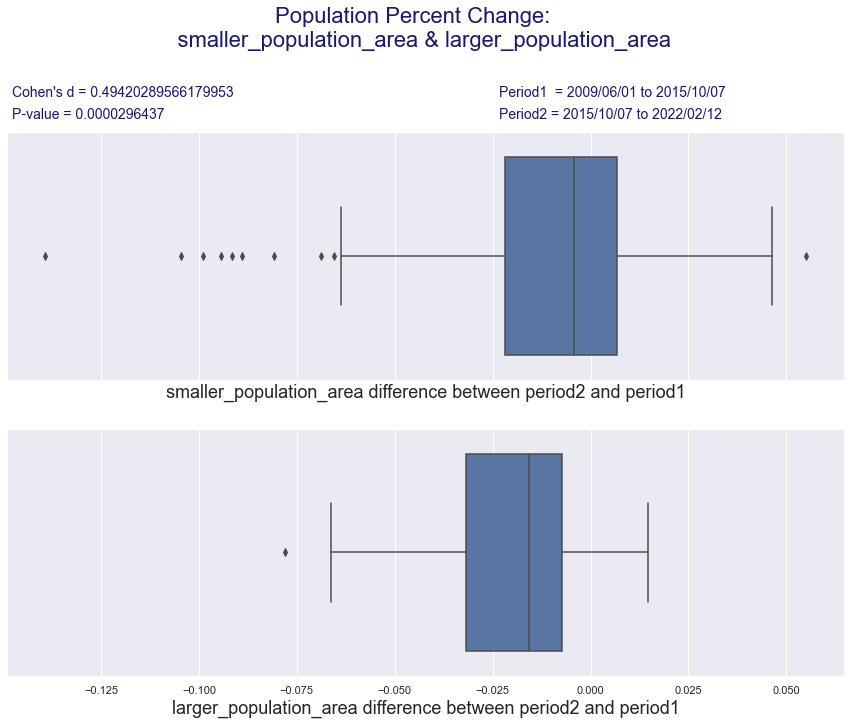

In [19]:
show_code()

ptest(smaller_population_area,larger_population_area,3,"Population")

hello

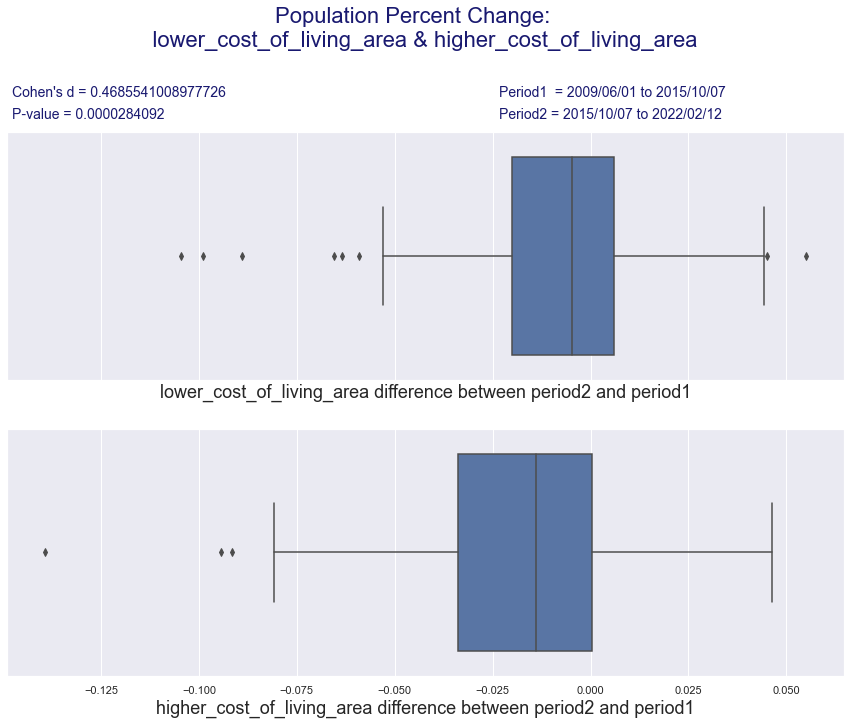

In [20]:
show_code()
ptest(lower_cost_of_living_area,higher_cost_of_living_area,3, "Population")

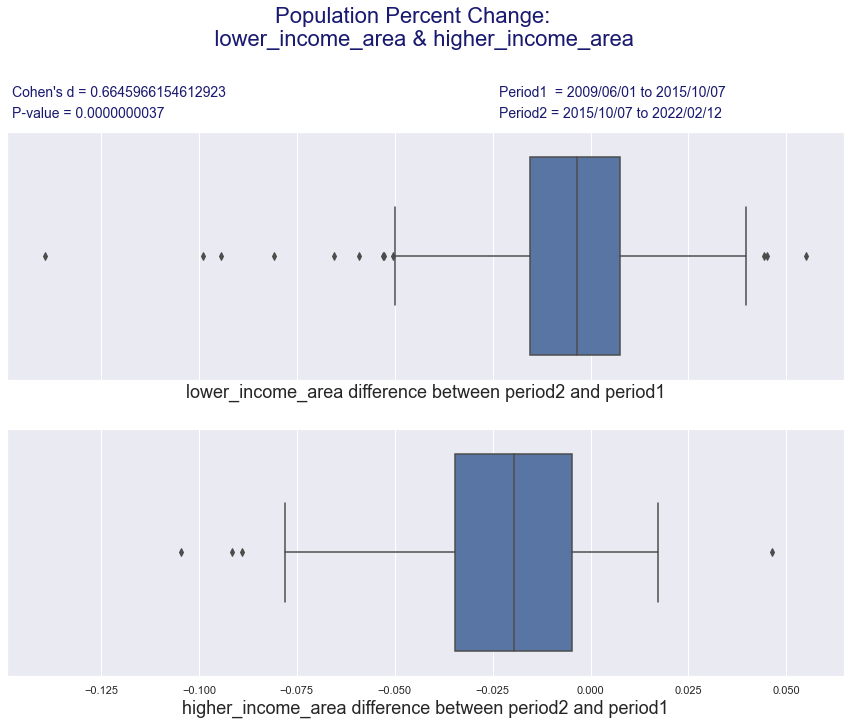

In [21]:
show_code()
ptest(lower_income_area,higher_income_area,3,"Population")

###### Home Value Change
> Percentage of change is calculated from each time period. From there Period2 is subtracted from Period1 to determine the most exponential growth area within the current time period.

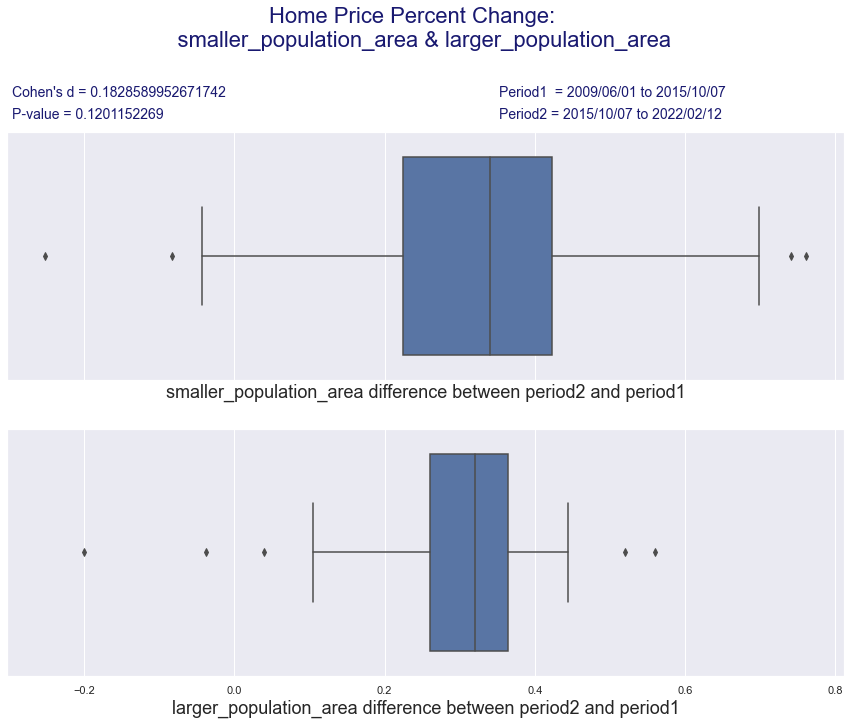

In [22]:
show_code()
ptest(smaller_population_area,larger_population_area,9,"Home Price")

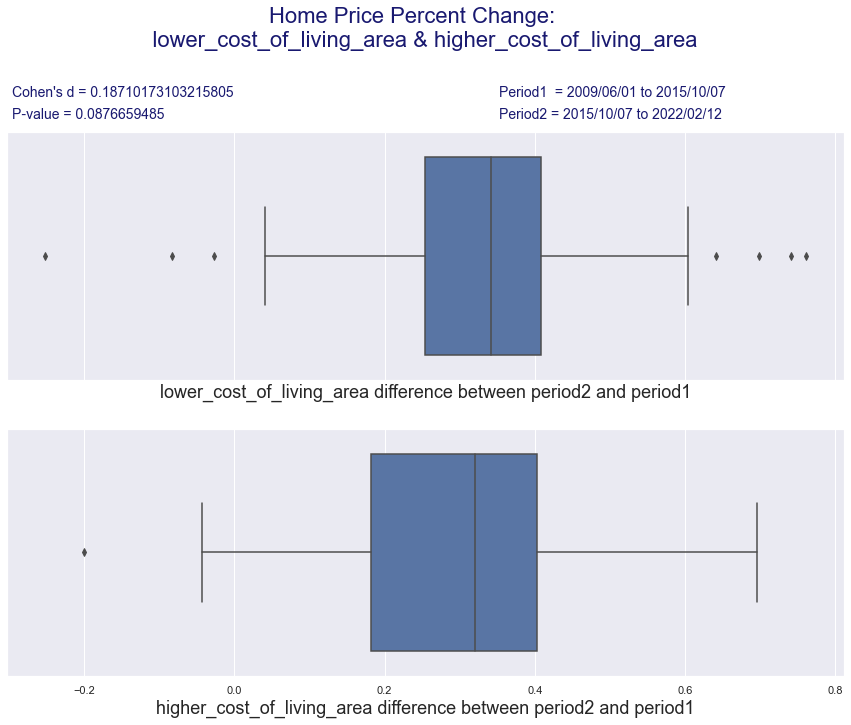

In [23]:
show_code()
ptest(lower_cost_of_living_area,higher_cost_of_living_area,9, "Home Price")

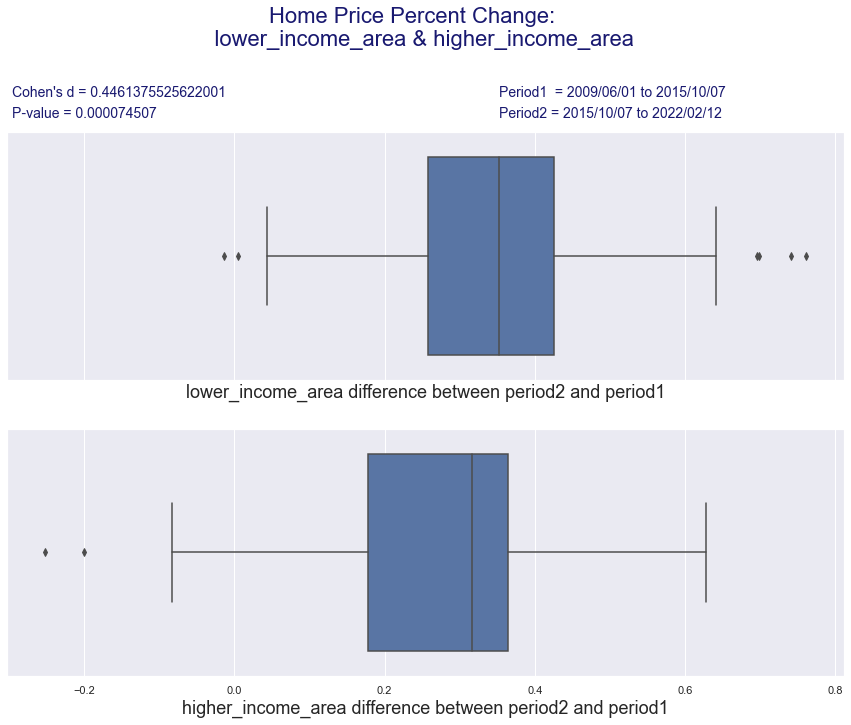

In [24]:
show_code()
ptest(lower_income_area,higher_income_area,9,"Home Price")

# Final Output Results

##### Sort With Combined Values From All DataFrames

###### Period_1 = Multiplier for first time period weighting.  Zero equals remove this data from results.

###### Period_2 = Multiplier for second time period weighting. Zero equals remove this data from results.

###### State    = Enter the two letter state abbreviation to see individual state results.

In [25]:
show_code()

#print("Period_1     = Multiplier for first time period weighting.  Zero equals remove this data from results.")
#print("Period_2     = Multiplier for second time period weighting. Zero equals remove this data from results.")
#print("State        = Enter the two letter state abbreviation to see individual state results")

filter_list =[eval(x) for x in filter_list]
(interact(combiner,Trend_filter = False, Period_1=(0,2),Period_2=(0,2),State = '', ShowAll = False))

interactive(children=(Checkbox(value=False, description='Trend_filter'), IntSlider(value=1, description='Perio…

<function __main__.combiner(Trend_filter, Period_1, Period_2, State, ShowAll)>

Text(0, 0.5, '')

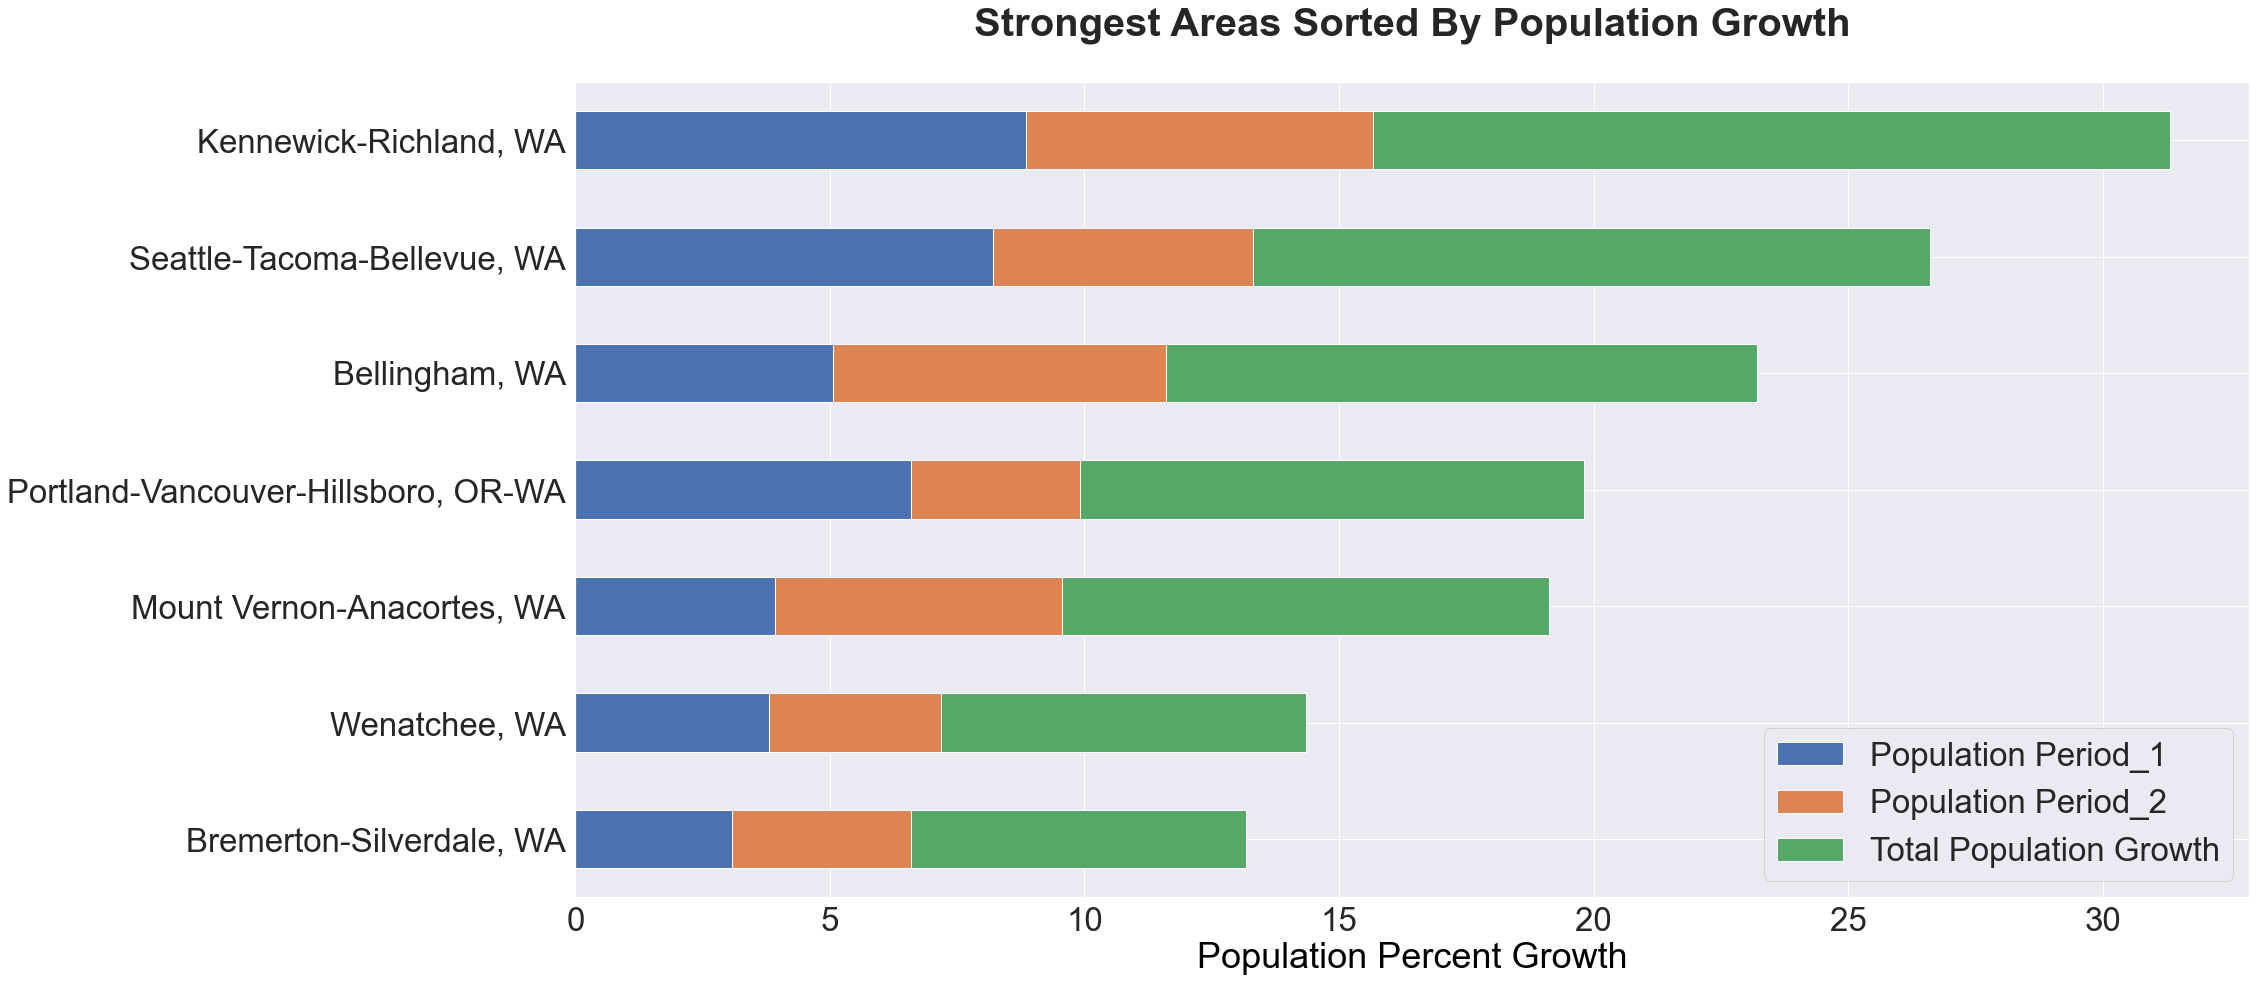

In [30]:
show_code()

d = pd.read_csv(finished_csv_file)
d = d.iloc[:,1:]
cols = list(d.columns)
d = d.head(15)

d['Total Population Growth'] = d[cols[1]]+d[cols[2]]
d['Total Home Price Increase'] = d[cols[5]]+d[cols[6]]
d['Total GDP Increase'] = d[cols[3]]+d[cols[4]]
d['Total Construction Labor Increase'] = d[cols[7]]+d[cols[8]]

d.sort_values(by = 'Total Population Growth', inplace =True, ascending = True)
sns.set(font_scale = 3.0)
fig, ax = plt.subplots(figsize=(30, 15))
d.plot(x=cols[0], y=[cols[1], cols[2],'Total Population Growth'], kind="barh",stacked=True,rot=0, ax = ax)
ax.yaxis.label.set_color('grey') 
ax.xaxis.label.set_color('black')
ax.set_title('Strongest Areas Sorted By Population Growth',fontdict= { 'fontsize': 40, 'fontweight':'bold'}, y =1.05)
plt.xlabel('Population Percent Growth')
plt.ylabel('')

Text(0, 0.5, '')

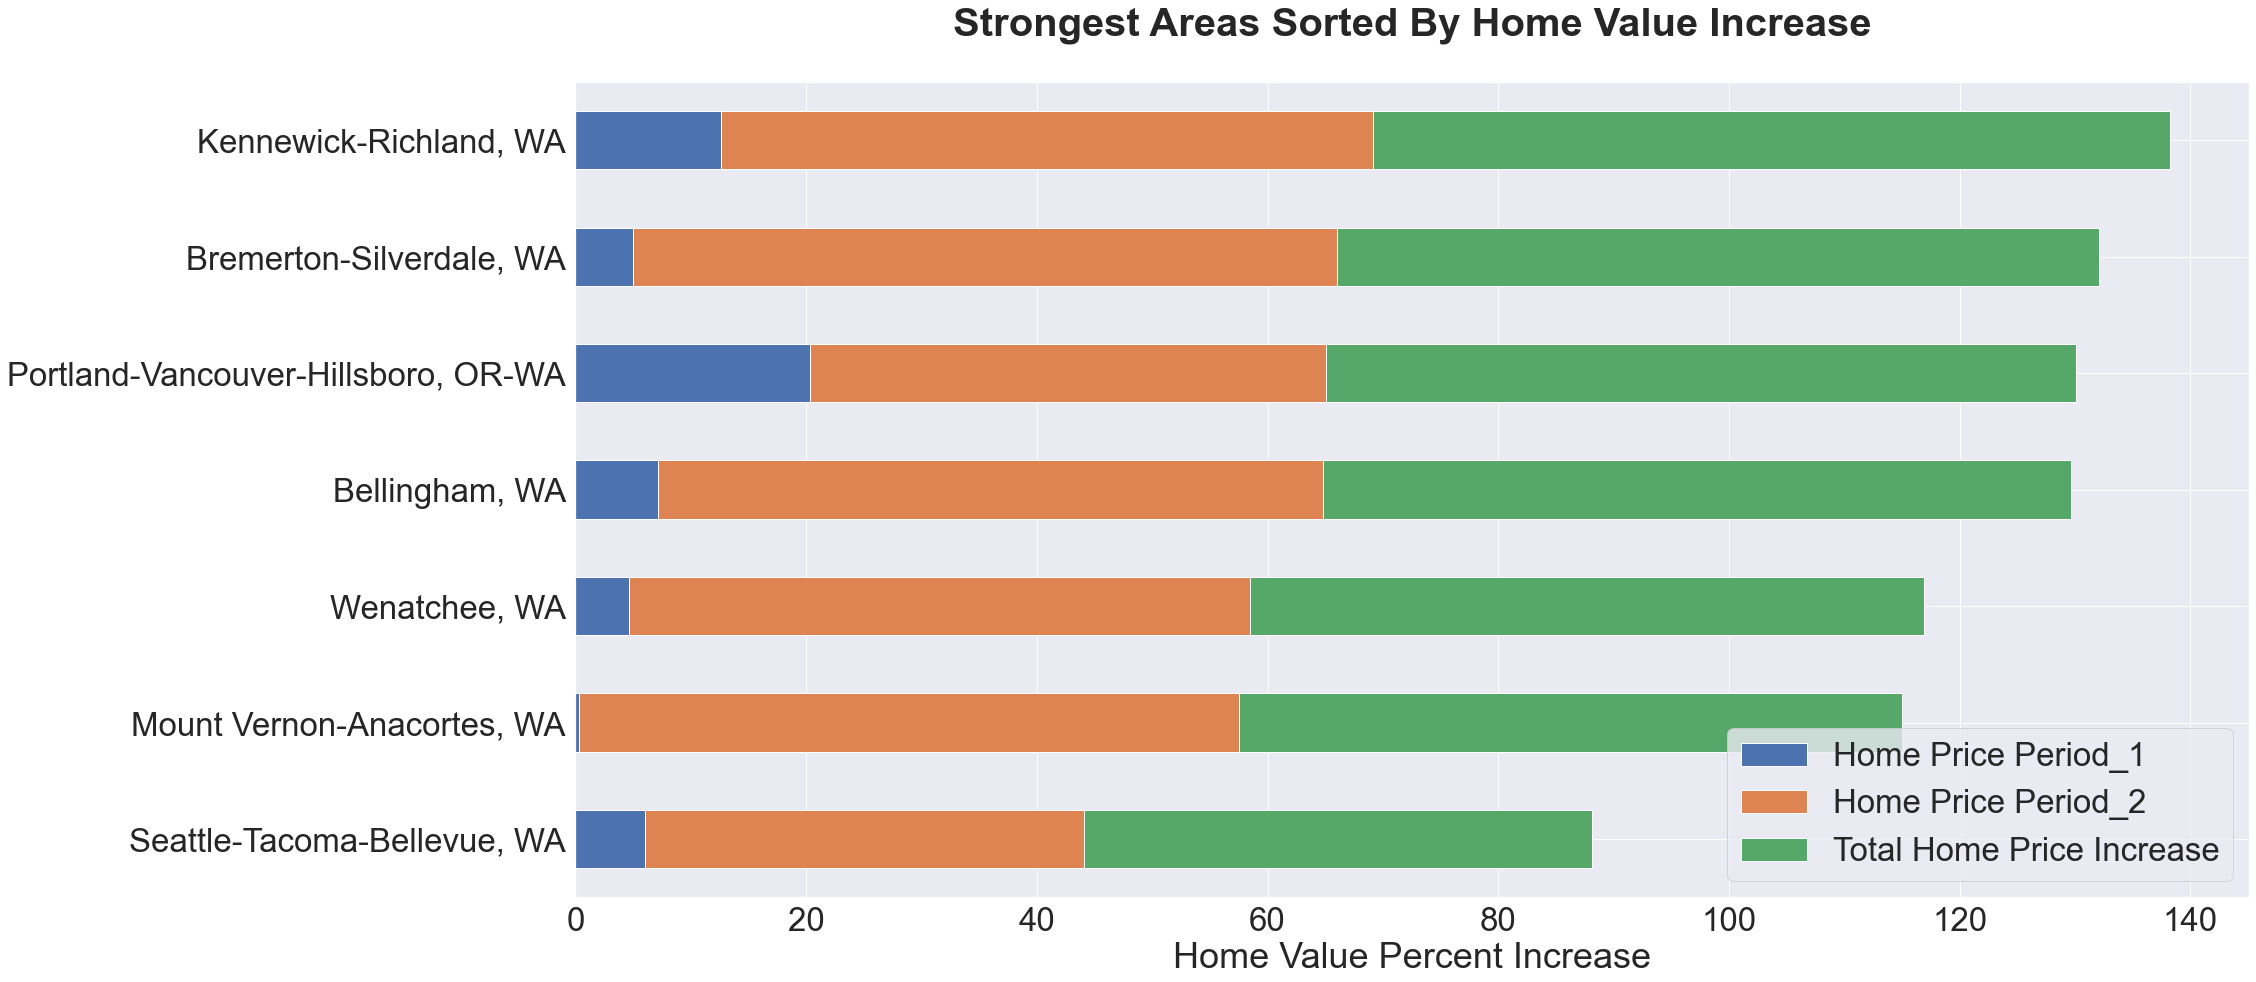

In [31]:
show_code()

d.sort_values(by = 'Total Home Price Increase', inplace =True, ascending = True)
fig, ax = plt.subplots(figsize=(30, 15))
d.plot(x=cols[0], y=[cols[5], cols[6],'Total Home Price Increase'], kind="barh",stacked=True,rot=0, ax = ax)

ax.set_title('Strongest Areas Sorted By Home Value Increase',fontdict= { 'fontsize': 40, 'fontweight':'bold'}, y =1.05)
plt.xlabel('Home Value Percent Increase')
plt.ylabel('')

Text(0, 0.5, '')

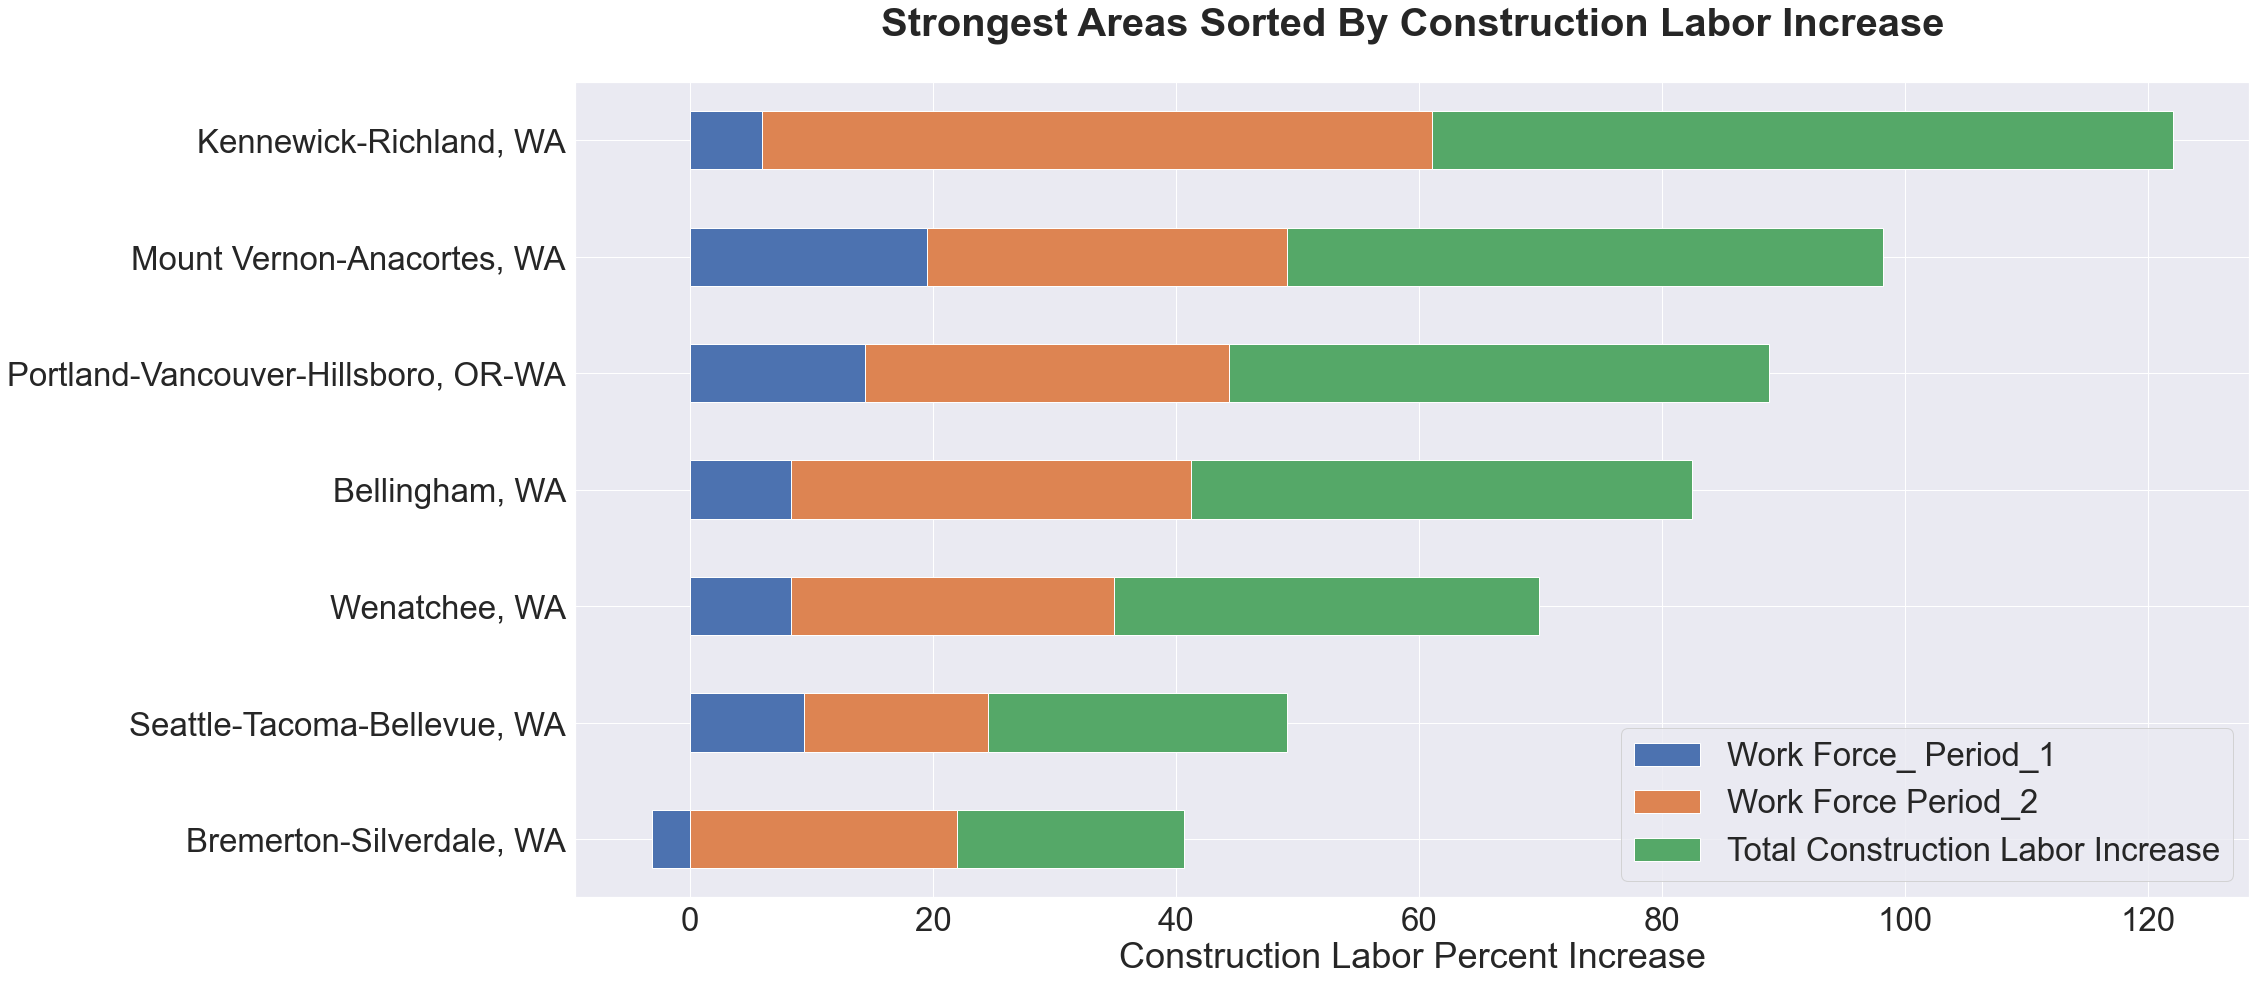

In [32]:
show_code()

d.sort_values(by = 'Total Construction Labor Increase', inplace =True, ascending = True)
fig, ax = plt.subplots(figsize=(30, 15))
d.plot(x=cols[0], y=[cols[7], cols[8],'Total Construction Labor Increase'], kind="barh",stacked=True,rot=0, ax = ax)

ax.set_title('Strongest Areas Sorted By Construction Labor Increase',fontdict= { 'fontsize': 40, 'fontweight':'bold'}, y =1.05)
plt.xlabel('Construction Labor Percent Increase')
plt.ylabel('')

In [33]:
#!/usr/bin/env python3
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {
        "theme": "sky",
        "transition": "zoom",
        "start_slideshow_at": "beginning",
        "scroll": "true"
     }
)

{'theme': 'sky',
 'transition': 'zoom',
 'start_slideshow_at': 'beginning',
 'scroll': 'true'}